In [1]:
import rospy
from geometry_msgs.msg import Pose, Point
from follow_goal.srv import GoalNumber
from follow_goal.msg import PlanningAction
from std_srvs.srv import *
from nav_msgs.msg import Odometry
import follow_goal.msg
import actionlib
import actionlib.msg
%matplotlib widget
import matplotlib.pyplot as plt
import rospy
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display
from sensor_msgs.msg import LaserScan
import jupyros as jr
import time
import rospy
import math

In [2]:
global user, status, posx, posy

rospy.init_node('user_interface')
user=actionlib.SimpleActionClient('/reaching_goal', follow_goal.msg.PlanningAction)
user.wait_for_server()
status=user.get_state()
posx=40
posy=40

In [3]:

posx_widget =widgets.FloatText( description='Pos x:', disabled=False)
posy_widget =widgets.FloatText( description='Pos y:', disabled=False)

confirm_goal=widgets.Button(description="Confirm goal")
output_confirm=widgets.Output()

cancell_goal=widgets.Button(description="Cancel a goal")
output_cancell = widgets.Output()

menu=widgets.VBox([posx_widget, posy_widget, confirm_goal, cancell_goal])


In [4]:
global user, status, posx, posy

def on_confirm_clicked(confirm_goal):
    #global posx, posy
    posx=float(posx_widget.value)
    posy=float(posy_widget.value)
    with output_confirm:
        send_goal()
confirm_goal.on_click(on_confirm_clicked)

def send_goal():
    goal = follow_goal.msg.PlanningGoal()
    status=user.get_state()
    if not (status==actionlib.GoalStatus.ACTIVE):
        goal.target_pose.pose.position.x = posx
        goal.target_pose.pose.position.y = posy
        user.send_goal(goal)
        print("Goal sent!")
    else:
        print("Goal has been already set")

def on_cancell_clicked(cancell_goal):
    with output_cancell:
        cancel_f()
cancell_goal.on_click(on_cancell_clicked)

def cancel_f():
    status=user.get_state()
    if status==actionlib.GoalStatus.ACTIVE:
        user.cancel_goal()
        print("Goal cancelled")
    else:
        print("No goal has been set")


print("Click on one of the following options:")
#display(menu, output_confirm, output_cancell)

Click on one of the following options:


In [5]:
global posx, posy, user, status

class Visualiser:
    def __init__(self):
        self.fig, (self.ax, self.ax2) = plt.subplots(1,2, figsize=(10,4))
        self.ln, = self.ax.plot([], [], marker='o', color='red', markersize='4', label='Trajectory')
        self.ax.plot(posx, posy, marker='*', color='green', markersize='10', label='Target reached')
        self.ax.plot(posx, posy, marker='*', color='orange', markersize='10', label='Current target')
        self.ax.plot(posx, posy, marker='*', color='blue', markersize='10', label='Deleted target')
        self.posx=posx
        self.posy=posy
        self.x_data, self.y_data = [] , []
        self.reached = 0
        self.deleted = 0
        self.reach=False
        self.eliminated=False
    def plot_init(self):
        self.ax.set_xlim(-30, 30)
        self.ax.set_ylim(-30, 30)
        self.ax2.set_ylim(0, 10)
        return self.ln
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        current_px_widget.value=round(msg.pose.pose.position.x, 3)
        current_py_widget.value=round(msg.pose.pose.position.y, 3)
    def update_plot(self, frame):
        global posx, posy
        self.ln.set_data(self.x_data, self.y_data)
        self.posx=posx
        self.posy=posy
        status=user.get_state()
        #check if status is reached
        if status==3 and not(self.reach):
            self.ax.plot(self.posx, self.posy, marker='*', color='green', markersize='10', label='Reached Target')
            self.reached+=1
            self.ax2.bar(['reached', 'deleted'], [self.reached, self.deleted], color = 'b')
            self.reach=True
        #check if status is deleted
        elif status==2 and not(self.eliminated):
            self.ax.plot(self.posx, self.posy, marker='*', color='blue', markersize='10', label='Deleted Target')
            self.deleted+=1
            self.ax2.bar(['reached', 'deleted'], [self.reached, self.deleted], color = 'b')
            self.eliminated=True
        elif (not(status==3) and self.reach):
            self.reach=False 
        elif (not(status==2) and self.eliminated):
            self.eliminated=False
        elif (not(status==3) and not(status==2)):
            self.ax.plot(self.posx, self.posy, marker='*', color='orange', markersize='10', label='CUrrent Target')
        
        self.ax2.bar(['reached', 'deleted'], [self.reached, self.deleted], color = 'b')
        return self.ln

In [6]:
min_dist_widget =widgets.FloatText( description='Dist to obstacle:', disabled=True)
output_dist=widgets.Output()
current_px_widget=widgets.FloatText(description='Current posx:', disabled=True)
current_py_widget=widgets.FloatText(description='Current posy:', disabled=True)

In [8]:
global min_range

def scan_callback(scan):
    min_range = scan.range_max
    for range_val in scan.ranges:
        if range_val < min_range:
            min_range = range_val
    min_dist_widget.value=round(min_range, 3)
    time.sleep(0.5)

jr.subscribe('/scan', LaserScan, scan_callback)

/tmp/ipykernel_5915/2716976453.py:17: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)


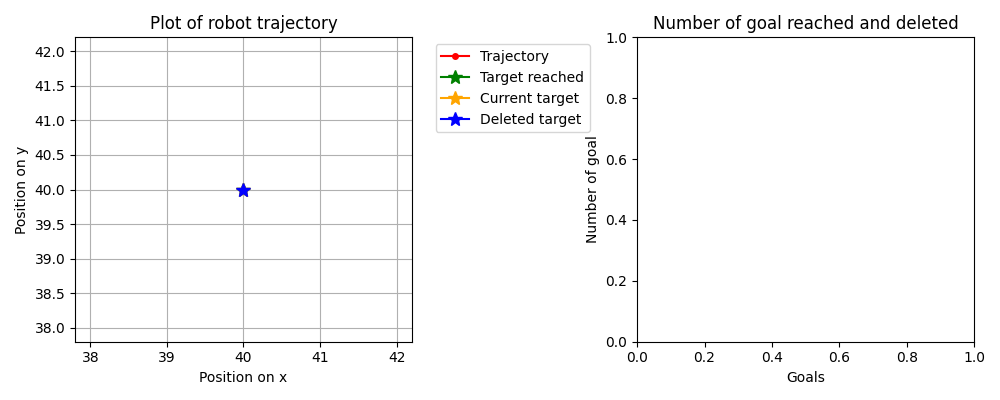

Insert a goal:


Output()

Output()

FloatText(value=0.0, description='Dist to obstacle:', disabled=True)

Output()

FloatText(value=-0.115, description='Current posx:', disabled=True)

FloatText(value=1.007, description='Current posy:', disabled=True)

In [7]:


vis = Visualiser()
vis.ax.set_title('Plot of robot trajectory')
vis.ax.set_xlabel('Position on x')
vis.ax.set_ylabel('Position on y')
vis.ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
vis.ax.grid()

vis.ax2.set_title('Number of goal reached and deleted')
vis.ax2.set_xlabel('Goals')
vis.ax2.set_ylabel('Number of goal')



sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
time.sleep(0.2)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)


plt.show(block=True)

print("Insert a goal:")
display(menu, output_confirm, output_cancell)
display(min_dist_widget, output_dist)
display(current_px_widget)
display(current_py_widget)